# FPL Predictor Modeling III

### Package Installments

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = "ticks")
%matplotlib inline
from scipy.interpolate import make_interp_spline
import math
import pickle

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/accre/arch/easybuild/software/BinDist/Anaconda3/5.0.1/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### Useful functions

In [3]:
## This function is used to select the best degree for polynomial regression
def best_degree(model, df_x,df_y):
    degree = np.arange(10)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    degree = pd.Series(degree)
    train = pd.Series(np.median(train_score,1))
    val = pd.Series(np.median(val_score,1))
    record = pd.DataFrame({'degree': degree, 'train_score': train, 'val_score': val})
    record_max = record.loc[record[['val_score']].idxmax(), 'degree']
    record_max2 = record_max.reset_index(drop = True)
    return record_max2[0]

In [4]:
## This function is used to see how the training curve and validation curve vary for different degrees
def val_curve(model, df_x, df_y):
    degree = np.arange(1,6)
    train_score, val_score = validation_curve(model, df_x, df_y, 'polynomialfeatures__degree', degree, cv = 5)
    best = best_degree(model,df_x,df_y)
    deg = np.linspace(1,5,200)
    smooth_train = make_interp_spline(degree, np.median(train_score,1))
    smooth_val = make_interp_spline(degree, np.median(val_score, 1))

    ##plt.plot(degree, np.median(train_score,1), color = 'blue', label = 'training curve')
    ##plt.plot(degree, np.median(val_score,1), color = 'red', label = 'validation curve')
    plt.plot(deg, smooth_train(deg), color = 'blue', label = 'training curve')
    plt.plot(deg, smooth_val(deg), color = 'red', label = 'validation curve')
    plt.scatter(best, np.max(np.median(val_score,1)), marker = 'x', color = 'black', label = 'max')
    plt.legend(loc = 'best')
    plt.xlabel('Degree')
    plt.ylabel('Accuracy score')
    plt.ylim(0,1);

In [5]:
## This function is used split data into training and testing sets
def split_data(df_new, rand_state = 10):
    df_x = df_new[['player_name','goals_scored', 'assists','minutes', 'position_index','clean_sheets', 'total_points']]
    df_y = df_new['total_points']
    df_xm = df_new[['goals_scored','assists','minutes','clean_sheets','position_index']]
    df_xtrain, df_xtest, df_ytrain, df_ytest = train_test_split(df_x, df_y, random_state = rand_state, train_size = 0.8)
    df_xtrain_new = df_xtrain[['goals_scored', 'assists','minutes','clean_sheets','position_index']]
    df_xtest_new = df_xtest[['goals_scored', 'assists','minutes','clean_sheets','position_index']]
    return (df_x, df_y, df_xm, df_xtrain, df_xtest, df_ytrain, df_ytest, df_xtrain_new, df_xtest_new)

In [6]:
## This function is used to generate a new table with the fpl predictions
def new_output(df_x, df_y, df_pred):
    df_xtest = df_x.copy()
    df_xtest['fpl_pred'] = df_pred
    df_xtest2 = df_xtest.reset_index()
    df_xtest2 = df_xtest2.drop("index", axis = 1)
    return df_xtest2

### Creating model

In [7]:
model = make_pipeline(PolynomialFeatures(), LinearRegression())

### ETL

In [8]:
## Loading the dataset
fpl_ult = pd.read_csv("~/DSI-SRP1/FPL_ULTIMATE.csv", encoding = "latin1")

In [9]:
fpl_ult.shape

(46659, 17)

In [10]:
fpl_ult.head()

,Unnamed: 0,player_name,club_name,position,position_index,goals_scored,assists,ict_index,goals_conceded,minutes,own_goals,total_points,bps,bonus,clean_sheets,GW,season
0,1,Aaron Lennon,Everton FC,Right Winger,4,0,0,0.9,0,15,0,1,6,0,0,1,2016/2017
1,2,Aaron Ramsey,Arsenal FC,Central Midfield,3,0,0,3.0,3,60,0,2,5,0,0,1,2016/2017
2,3,Abel Hernández,Hull City,Centre-Forward,5,0,1,5.7,1,90,0,5,10,0,0,1,2016/2017
3,4,Adama Diomande,Hull City,Centre-Forward,5,1,0,10.7,1,90,0,8,29,2,0,1,2016/2017
4,5,Adam Clayton,Middlesbrough FC,Defensive Midfield,3,0,0,1.4,1,90,0,2,6,0,0,1,2016/2017


In [11]:
fpl_ult = fpl_ult.drop("Unnamed: 0", axis = 1)

In [12]:
fpl_ult.columns

Index(['player_name', 'club_name', 'position', 'position_index',
       'goals_scored', 'assists', 'ict_index', 'goals_conceded', 'minutes',
       'own_goals', 'total_points', 'bps', 'bonus', 'clean_sheets', 'GW',
       'season'],
      dtype='object')

In [13]:
fpl_ult.shape

(46659, 16)

### Feature Selection

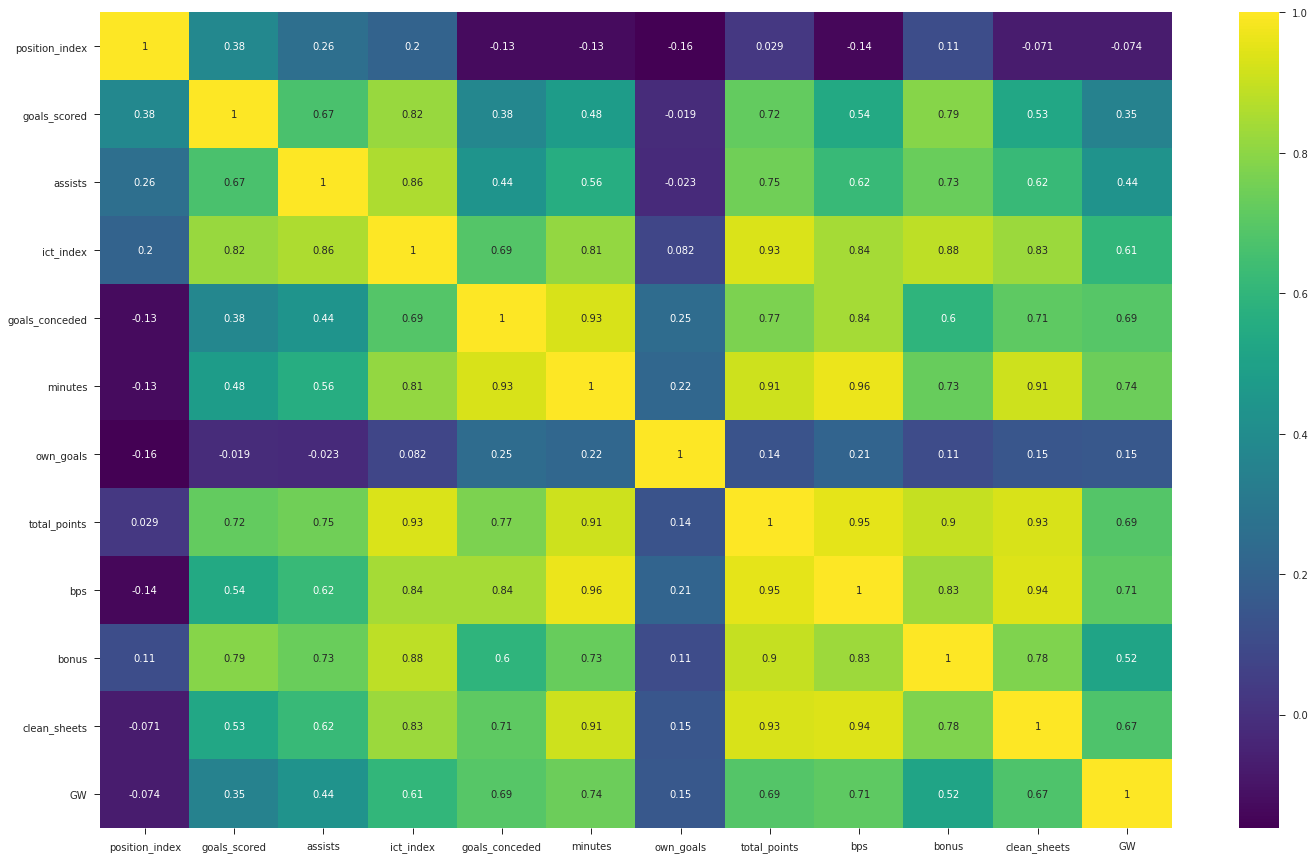

In [14]:
## plotting the correlation coefficient table
plt.figure(figsize = (24,15))
cor = fpl_ult.corr()
sns.heatmap(cor, annot = True, cmap = 'viridis')
plt.show()

In [15]:
##  Using Recursive Feature Elimination to select variables
fpl_newx = fpl_ult[['goals_scored','assists','minutes','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','GW']]
fpl_newy = fpl_ult['total_points']
model2 = LinearRegression()
model_rfe = RFE(model2,4)
fpl_x_rfe = model_rfe.fit_transform(fpl_newx, fpl_newy)
model2.fit(fpl_x_rfe, fpl_newy)
rfe = model_rfe.ranking_
features = ['goals_scored','assists','minutes','bonus','bps','goals_conceded', 'clean_sheets','ict_index','position_index','GW']
ref_df = pd.DataFrame({'features': features, 'rfe_rank': rfe}, index = np.arange(10))
ref_df[ref_df['rfe_rank'] == 1]

,features,rfe_rank
0,goals_scored,1
1,assists,1
6,clean_sheets,1
8,position_index,1


In [16]:
## minutes was selected because intuitively speaking the number of minutes a player plays has an influence on his total_points
fpl_newx2 = fpl_ult[['goals_scored', 'assists','clean_sheets', 'position_index', 'minutes']]
model_rfe2 = RFE(model2, 1)
fpl_x_rfe2 = model_rfe2.fit_transform(fpl_newx2, fpl_newy)
model2.fit(fpl_x_rfe2, fpl_newy)
rfe2 = model_rfe2.ranking_
features2 = ['goals_scored','assists','clean_sheets','position_index', 'minutes']
rfe_df2 = pd.DataFrame({'features': features2, 'rfe_rank': rfe2}, index = np.arange(5))
rfe_df2 = rfe_df2.sort_values('rfe_rank')
rfe_df3 = rfe_df2.reset_index()
rfe_df3 = rfe_df3.drop('index', axis = 1)
rfe_df3

,features,rfe_rank
0,clean_sheets,1
1,goals_scored,2
2,position_index,3
3,assists,4
4,minutes,5


### Modeling

In [17]:
fpl_x, fpl_y, fpl_xm, fpl_xtrain, fpl_xtest, fpl_ytrain, fpl_ytest, fpl_xtrain_new, fpl_xtest_new = split_data(fpl_ult)

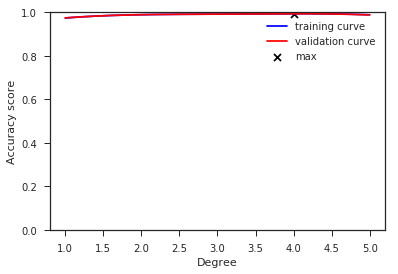

In [18]:
val_curve(model, fpl_xtrain_new, fpl_ytrain)

In [19]:
## building a new model based on the best degree
model_fpl = make_pipeline(PolynomialFeatures(best_degree(model, fpl_xtrain_new, fpl_ytrain)), LinearRegression())

In [20]:
score_fpl = cross_val_score(model_fpl, fpl_xtrain_new, fpl_ytrain, cv = 5, scoring = "r2")
print(score_fpl)
print(score_fpl.mean())

[ 0.99407267  0.99391209  0.99392076  0.99306947  0.99370322]
0.99373564364


In [21]:
## fitting the model
model_fpl.fit(fpl_xtrain_new, fpl_ytrain)
fpl_pred = model_fpl.predict(fpl_xtest_new)

In [22]:
fpl_r2 = r2_score(fpl_pred, fpl_ytest)

In [23]:
fpl_rmse = math.sqrt(mean_squared_error(fpl_pred, fpl_ytest))

In [24]:
fpl_evs = explained_variance_score(fpl_pred, fpl_ytest)

In [25]:
## creating a table for the metrics
index = [0,1,2]
measure = ['r-squared score', 'root mean squared error', 'explained variance score']
score = [fpl_r2, fpl_rmse, fpl_evs]
fpl_score_df = pd.DataFrame({'measure': measure, 'score': score}, index = index)
fpl_score_df

,measure,score
0,r-squared score,0.994007
1,root mean squared error,6.639374
2,explained variance score,0.994011


In [26]:
fpl_ult2 = new_output(fpl_xtest, fpl_ytest, fpl_pred)

In [27]:
fpl_ult2.head()

,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,fpl_pred
0,Andreas Pereira,0,0,135,4,0,2,5.720735
1,Dusan Tadic,4,7,3357,4,18,138,139.376345
2,Evandro Goebel,0,0,176,4,1,6,5.901951
3,Sead Kolasinac,2,4,2146,2,10,108,109.735833
4,Martin Cranie,0,0,179,2,0,2,3.062668


### 2019/20 sample dataset

In [28]:
## Loading a new data
fpl_test = pd.read_csv("~/DSI-SRP1/2019_20_sample.csv")

In [29]:
fpl_test.head()

,Unnamed: 0,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,fpl_to_game
0,1,Alisson,0,1,2363,1,13,119,4.532374
1,2,Bravo,0,0,347,1,1,11,2.853026
2,3,de Gea,0,0,3240,1,12,134,3.722222
3,4,Caballero,0,0,360,1,0,7,1.750000
4,5,Gunn,0,0,900,1,5,29,2.900000


In [30]:
fpl_test = fpl_test.drop("Unnamed: 0", axis = 1)
fpl_test.columns

Index(['player_name', 'goals_scored', 'assists', 'minutes', 'position_index',
       'clean_sheets', 'total_points', 'fpl_to_game'],
      dtype='object')

In [31]:
## testing out the model on a new dataset
fpl_testx = fpl_test[['goals_scored', 'assists','minutes','clean_sheets', 'position_index']]
fpl_testpred = model_fpl.predict(fpl_testx)

In [32]:
fpl_t = fpl_test.copy()
fpl_t['total_points_pred'] = fpl_testpred
fpl_t['fpl_to_game_pred'] = (fpl_testpred/fpl_test['minutes'])*90
fpl_t

,player_name,goals_scored,assists,minutes,position_index,clean_sheets,total_points,fpl_to_game,total_points_pred,fpl_to_game_pred
0,Alisson,0,1,2363,1,13,119,4.532374,124.208822,4.730763
1,Bravo,0,0,347,1,1,11,2.853026,14.590990,3.784407
2,de Gea,0,0,3240,1,12,134,3.722222,141.064002,3.918445
3,Caballero,0,0,360,1,0,7,1.750000,7.757785,1.939446
4,Gunn,0,0,900,1,5,29,2.900000,49.258031,4.925803
5,Pope,0,0,3330,1,15,169,4.567568,154.721039,4.181650
6,van Dijk,4,1,3240,2,15,168,4.666667,157.611545,4.378098
7,Coady,0,0,3240,2,12,116,3.222222,108.977199,3.027144
8,Rico,0,3,2242,2,6,77,3.090990,73.016333,2.931075
9,Cahill,0,1,2167,2,7,70,2.907245,70.813559,2.941034
